# Pathfinder tests

The goal of this module is to test the functionality of the pathfinder modules using the pre-saved data from the fullscan pathfinder.

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import json
import pandas as pd
from scipy.interpolate import griddata
from scipy.interpolate import LinearNDInterpolator

%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
sys.path.append('..\\')
from Pathfinders import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Unload the data from a particular scan
This should only include data from a Fullscan module

In [22]:
path = os.path.abspath('..\\')
test_no = 15
# current_file = r"\Debugging Scripts\Scans\test_%s.json" % test_no
current_file = r"\Scans\test_%s.json" % test_no

debug_mode = True

### JSON Unpacking
Using the above file number and path, the scan data is unpacked from the corresponding JSON file. Unpacking the data can take around ~15 seconds depending on the length of the file, so a #TODO item is to create code for running a pathfinder directly off a math equation.

In [23]:
with open(path + current_file, 'r') as infile:
    json_data = json.load(infile)


r_o_m = json_data["range of motion"]
resolution = json_data["resolution"]
point_mags = json_data["points"]
scan_max = json_data["max_point"]

# indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
# points = np.array([[p[0][indices[a][0]][indices[a][1]] for a in active_rom] for p in point_mags])
# mags = np.array([p[1] for p in point_mags])

points = np.array(point_mags)
active_rom = json_data["active_ROM"]
cols = active_rom.copy()
cols.append("mag")

data = pd.DataFrame(data=points, columns=cols)

points = data[active_rom]
mags = data['mag']
mp = data.loc[data['mag'].idxmax()]

In [24]:
print(points.shape)
print(mags.shape)
linInter = LinearNDInterpolator(points, mags,fill_value=-1)

r = dict()
for DoF in r_o_m:
    r[DoF] = (r_o_m[DoF][1] - r_o_m[DoF][0]) / 2


if debug_mode:
    print(f"Active range of motion: {active_rom}")
    print(point_mags[0])
    print(type(point_mags))
    print(r_o_m)
    print(np.shape(points))
    print(r)
    print(resolution)

(9471, 3)
(9471,)
Active range of motion: ['Z', 'Rx', 'Ry']
[-10.0, -20.0, -20.0, 19.210551927307698]
<class 'list'>
{'X': [0, 0], 'Y': [0, 0], 'Z': [-10, 10], 'Rx': [-20, 20], 'Ry': [-20, 20], 'Rz': [0, 0]}
(9471, 3)
{'X': 0.0, 'Y': 0.0, 'Z': 10.0, 'Rx': 20.0, 'Ry': 20.0, 'Rz': 0.0}
[0.5, 2]


In [30]:
# scanner = Discrete_degree(r['Z'], r['Rx'], r['Ry'])
# scanner = DivisionDiscreteDegree(4, r['Z'], r['Rx'], r['Ry'], cutoff_mag=50)
scanner = Greedy_discrete_degree(r['Z'], r['Rx'], r['Ry'],bias=2,steps=4)

p = scanner.next()
i = 0

indices = {'X': (0,0), 'Y': (0,1), 'Z': (0,2), 'Rx': (1,0), 'Ry': (1,1), 'Rz': (1,2)}
# offset = {'X': 0., 'Y': 0., 'Z': -9., 'Rx': -8., 'Ry': 8., 'Rz': 0.}
offset = np.array([0,0,-2,-1,2,0])

while type(p) is not int and i < 10000:
    i += 1

    request = p + offset
    # print(f"Reuqest: {request}")
    mag = linInter(request)

    if mag[0] == -1:
        mag[0] = i * -20
    # print(f"magnitudes:{mag}")
    # print(f"Value pushed: {np.append(p,mag[0])}")

    scanner.newMag(np.append(p,mag[0]),True)
    p = scanner.next()

if debug_mode:
    print(f"Number of points to solve: {i}")
    # print(path + output_file)
r_o_m = scanner.range_of_motion
point_mags_2 = scanner.points
search_max = scanner.max_point
active_rom = scanner.active_rom

cols = active_rom.copy()
cols.append("mag")

print(len(point_mags_2))

# scanner_points = np.array([p[0] for p in point_mags_2])
# scanner_mags = np.array([[p[1] for p in point_mags_2]])
scanner_dat = np.array(scanner.points)
# scanner_points = np.reshape(scanner_points,(scanner_points.shape[0],6))

scanner_data = pd.DataFrame(data=scanner_dat, columns=cols)


print(scanner_data.head())
a = np.array(point_mags_2[0])
distance = 0

for i in range(1, len(point_mags_2)):
    b = np.array(point_mags_2[i])
    t = np.sum((b - a)**2)

    distance += t**0.5
    a = b

# (x,y,z,Rx,Ry,Rz,mag) = search_max.tolist()
# search_max = (((x+offset['X'],y+offset['Y'],z+offset['Z']),(Rx+offset['Rx'],Ry+offset['Ry'],Rz+offset['Rz'])),mag)
search_max = search_max + np.append(offset.copy(),0)


for j in range(3):
    t += np.sum((scan_max[:3] - search_max[:3])**2)

degree_dist = np.arccos(np.cos(np.deg2rad(scan_max[3] - search_max[3])) 
            * np.cos(np.deg2rad(scan_max[4] - search_max[4])))
lin_dist = t**0.5

print("Pathfinder evalutation: ")
print(f"\tTotal search-space distance traveled: {distance}")
print(f"\tScan max value: {scan_max}")
print(f"\tSearch max value: {search_max}")
print(f"\tOffsets: {offset}")
print(f"\tDistance from target to found value: {lin_dist} mm, {degree_dist} deg")

0.8
Number of points to solve: 10000
10000
     Z   Rx   Ry        mag
0  0.0  0.0  0.0  22.021932
1  0.0  0.0  0.0  22.021932
2 -0.8  0.0  0.0  24.586261
3 -1.6  0.0  0.0  27.150589
4 -2.4  0.0  0.0  25.610158
Pathfinder evalutation: 
	Total search-space distance traveled: 8074.089230887289
	Scan max value: [0.0, 0.0, -7.0, 20.0, -20.0, 0.0, 109.375]
	Search max value: [ 0.          0.          4.4        -1.          2.          0.
 28.57398291]
	Offsets: [ 0  0 -2 -1  2  0]
	Distance from target to found value: 19.76157888428959 mm, 0.5244475625748055 deg


(-7981.600000001266, 0.0)
(0.0, 0.0)
(-5.6, 9.6)


C:\Users\ander\AppData\Local\Temp/ipykernel_16012/3068885563.py:19: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  ax.set_ybound((min(scanner_data['Ry']),max(scanner_data['Ry'])))


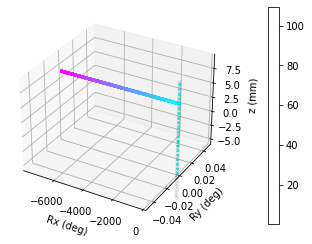

In [31]:
ax = plt.axes(projection='3d')
fig = ax.scatter(data['Rx'], data['Ry'], data['Z'], c=data['mag'], cmap='viridis', alpha=0.005, linewidth=0.05)
plt.colorbar(fig, pad=0.13,alpha=1)

# fig = ax.scatter(Rxs1, Rys1, Zs1, c=range(len(Zs1)), cmap='binary', alpha=0.8, linewidth=0.8, s=4)
fig = ax.scatter(scanner_data['Rx'], scanner_data['Ry'], scanner_data['Z'], c=range(len(scanner_data)), cmap='cool', alpha=0.8, linewidth=0.8, s=4)

ax.set_xlabel("Rx (deg)")
ax.set_ylabel("Ry (deg)")
ax.set_zlabel("z (mm)")
plt.rcParams['figure.dpi'] = 200

print((min(scanner_data['Rx']),max(scanner_data['Rx'])))
print((min(scanner_data['Ry']),max(scanner_data['Ry'])))
print((min(scanner_data['Z']),max(scanner_data['Z'])))


ax.set_xbound((min(scanner_data['Rx']),max(scanner_data['Rx'])))
ax.set_ybound((min(scanner_data['Ry']),max(scanner_data['Ry'])))
ax.set_zbound((min(scanner_data['Z']),max(scanner_data['Z'])))

# plt.savefig("fullscan_render.jpg", dpi=400)
plt.show()
# plt.axes(projection = "3d")
# plt.scatter(Rxs, Rys, Zs, c=mags, cmap='viridis', alpha=0.8, linewidth=0.5)
